In [1]:
!pip install fredapi > /dev/null

In [17]:
!pip install plotly > /dev/null

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time
plt.style.use('fivethirtyeight')
# pd.set_option('max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key = '5bcf7cdd204d38e3b983229d20b38f72'

# from kaggle_secrets import UserSecretsClient
# secrets = UserSecretsClient()
# fred_key = secrets.get_secret('fred-api')


# 1. Create The Fred Object

In [24]:
fred = Fred(api_key=fred_key)

# 2. Search for economic data!

In [25]:
sp_search = fred.search('S&P', order_by='popularity')

In [26]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2024-02-02,2024-02-02,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2024-02-01,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-02-02 08:47:03-06:00,92,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2024-02-02,2024-02-02,S&P CoreLogic Case-Shiller U.S. National Home ...,1987-01-01,2023-11-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2024-01-30 08:11:02-06:00,87,"For more information regarding the index, plea..."
SP500,SP500,2024-02-02,2024-02-02,S&P 500,2014-02-03,2024-02-01,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2024-02-01 19:10:59-06:00,83,The observations for the S&P 500 represent the...
MEHOINUSA672N,MEHOINUSA672N,2024-02-02,2024-02-02,Real Median Household Income in the United States,1984-01-01,2022-01-01,Annual,A,2022 CPI-U-RS Adjusted Dollars,2022 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2023-09-12 13:48:02-05:00,82,Household data are collected as of March. As ...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2024-02-02,2024-02-02,ICE BofA US High Yield Index Effective Yield,1996-12-31,2024-02-01,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-02-02 08:47:04-06:00,82,This data represents the effective yield of th...


# 3. Pull Raw Data & Plot

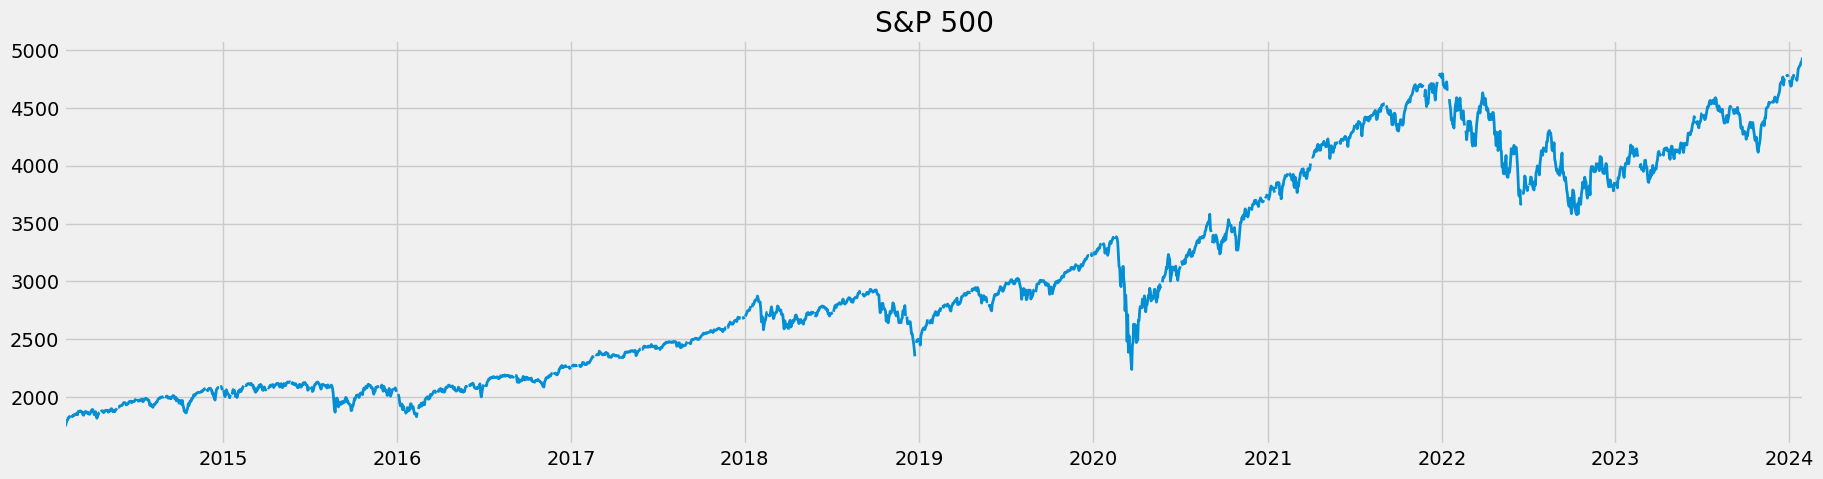

In [28]:
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(20, 5), title='S&P 500', lw=2)
plt.show()

# 4. Pull and Join Multiple Data Series

In [31]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]
len(unemp_df)

97

In [32]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
uemp_results = pd.concat(all_results, axis=1)

In [40]:
type(uemp_results)

pandas.core.frame.DataFrame

In [33]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [34]:
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [35]:
# Plot States Unemployment Rate
px.line(uemp_states)

# Pull April 2020 Unemployment Rate Per State

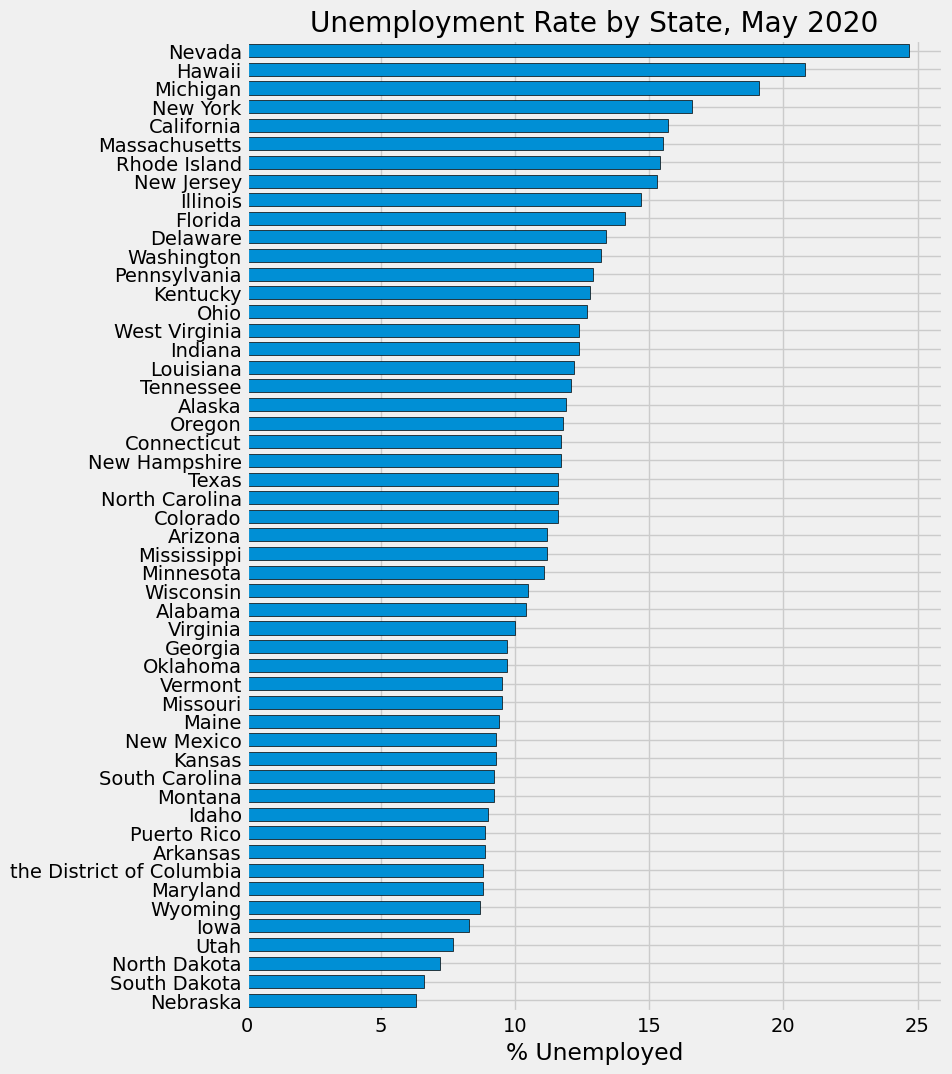

In [41]:
ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

# Pull Participation Rate

In [42]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [43]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

# Plot Unemployment vs Participation for each state!

In [44]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

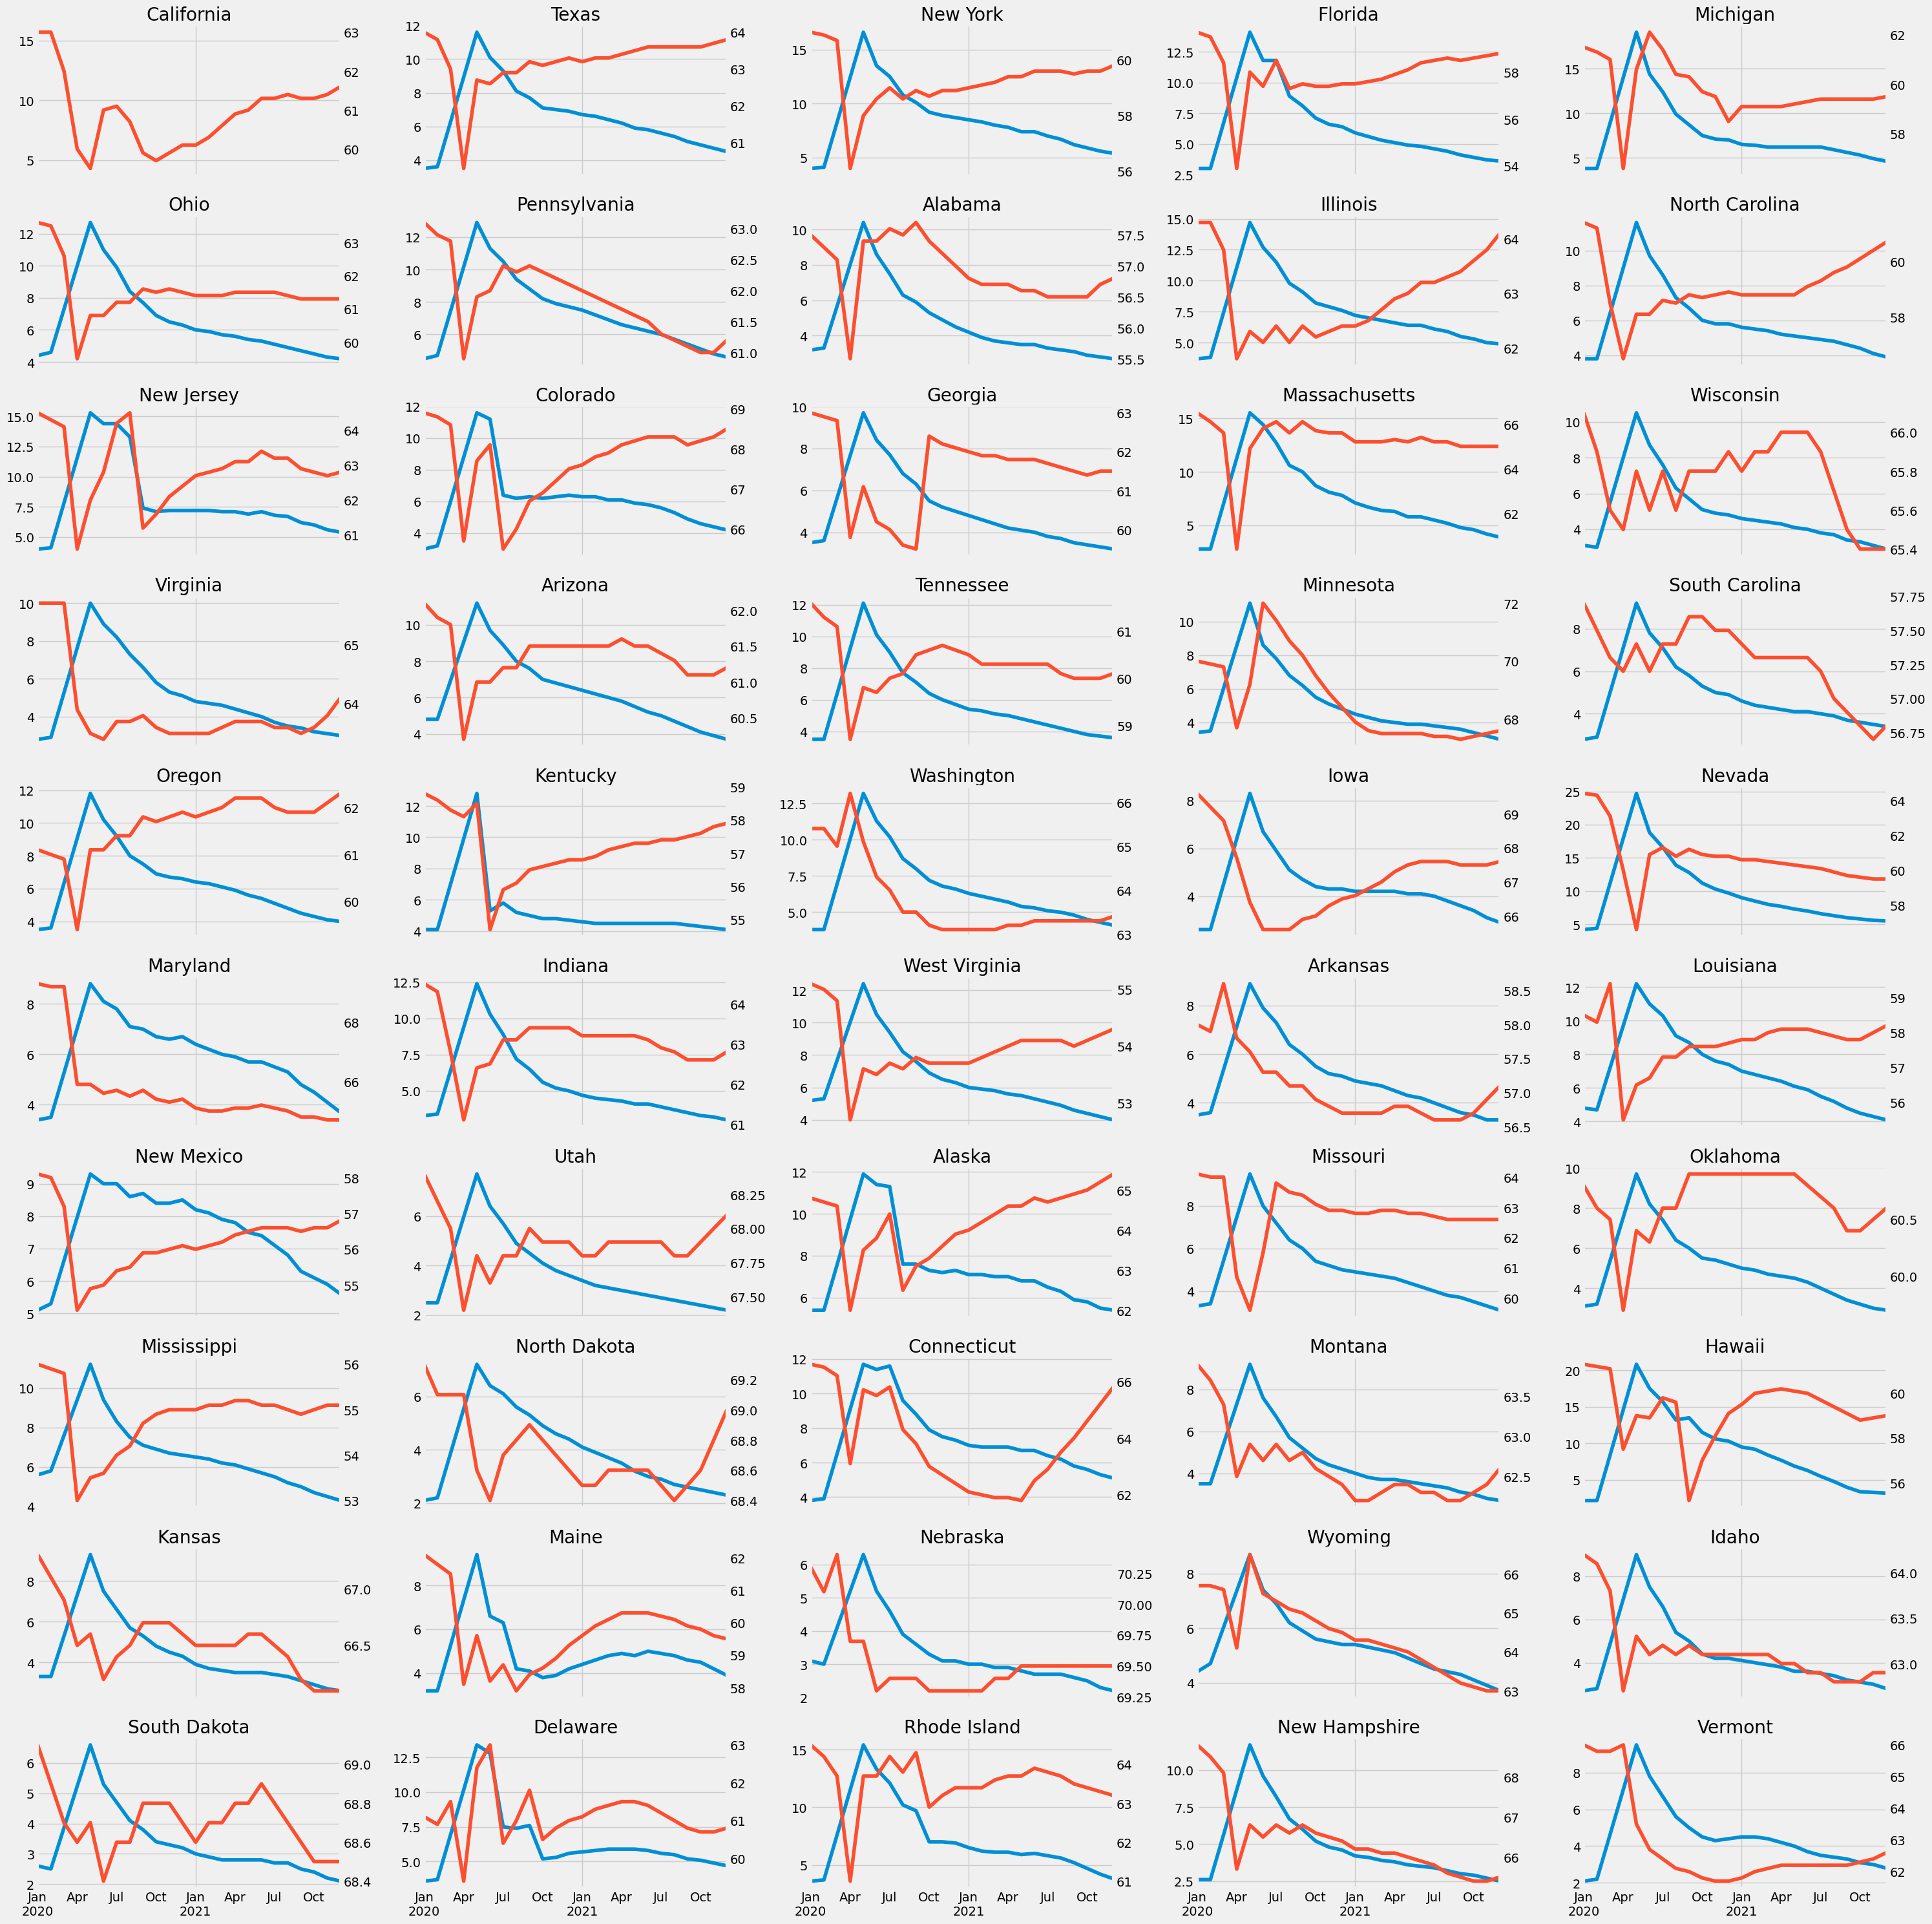

In [45]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()

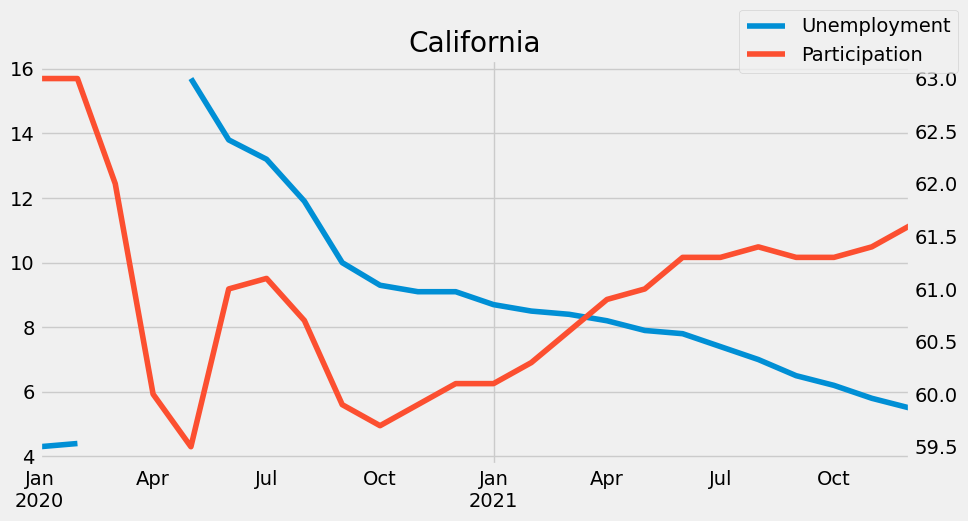

In [46]:
state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = uemp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()